In [1]:
from cdo import Cdo

cdo = Cdo()

In [2]:
%%bash
# duckdb -s "install spatial; load spatial; select id, name, st_xmin(geom), st_xmax(geom), st_ymin(geom), st_ymax(geom) from 'merit_hydro_catchments.gpkg';"
duckdb -s "install spatial; load spatial; select id, name, st_extent(geom) from 'merit_hydro_catchments.gpkg';"

┌──────────┬───────────────────────┬───────────────────────────────────────────────────────────────────────────────────┐
│    id    │         name          │                                  st_extent(geom)                                  │
│ varchar  │        varchar        │                                      box_2d                                       │
├──────────┼───────────────────────┼───────────────────────────────────────────────────────────────────────────────────┤
│ DE110000 │ Kirchen-Hausen        │ BOX(8.152079582214355 47.811248779296875, 8.729580879211426 48.15542221069336)    │
│ DE110010 │ Möhringen             │ BOX(8.152079582214355 47.811248779296875, 8.804580688476562 48.15542221069336)    │
│ DE110020 │ Hundersingen          │ BOX(8.152079582214355 47.811248779296875, 9.408750534057617 48.413753509521484)   │
│ DE110030 │ Berg                  │ BOX(8.152079582214355 47.811248779296875, 9.783750534057617 48.4970817565918)     │
│ DE110040 │ Achstetten         

In [36]:
import xarray as xr

da = xr.open_dataset('hurs_hyras_5_1952_v5-0_de.nc', decode_coords=True, mask_and_scale=True).hurs
ds = xr.Dataset({'hurs': da})
ds.to_dataframe().reset_index()[['time', 'x', 'y', 'hurs']].dropna().to_parquet('hurs_1952.parquet')

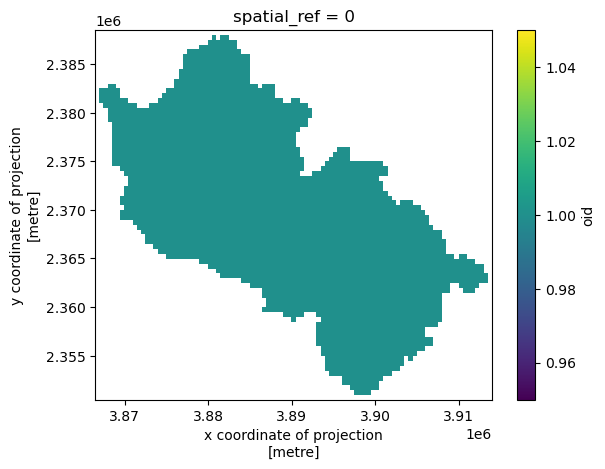

In [38]:
import geopandas as gpd
from geocube.api.core import make_geocube

gdf = gpd.read_file('merit_3034.gpkg')
gdf['oid'] = range(len(gdf))
#catchment = gdf.where(gdf['id'] == 'DE110010').dropna()

ds = make_geocube(gdf.where(gdf.id == 'DE110010').dropna(), measurements=['oid'], resolution=(-500, 500))
ds.oid.plot.imshow()

ds.to_dataframe().dropna().reset_index().astype(int)[['x', 'y', 'oid']].to_parquet('DE110010.parquet')

In [10]:
from app.db import HyrasDB
import tempfile
from geocube.api.core import make_geocube

db = HyrasDB()

catchments = db.catchments

catchments.to_crs('epsg:3034', inplace=True)
catchments['oid'] = range(len(catchments))

In [28]:
from pathlib import Path
import tqdm

base_path = Path('test/db/')

for i, row in catchments.iterrows():
    ds = make_geocube(catchments.where(catchments.oid == row.oid).dropna(), measurements=['oid'], resolution=(-500, 500))

    with tempfile.NamedTemporaryFile(suffix='.parquet') as f:
        ds.to_dataframe().dropna().reset_index().astype(int)[['x', 'y', 'oid']].to_parquet(f)
        f.seek(0)
        # generate path
        path = base_path / f"{row.id}/{row.id}.parquet"
        db.proc.upload(str(path), f.name)
    
    with tempfile.NamedTemporaryFile(suffix='.geojson') as f:
        # geojson
        catchments.where(catchments.id == row.id).dropna().to_file(f)

        path = base_path / f"{row.id}/{row.id}.geojson"
        db.proc.upload(str(path), f.name)
    
    break

In [29]:
for blob in db.proc.target.list_blobs(match_glob='**/*.parquet'):
    print(blob)
    print(blob.name)

    with tempfile.NamedTemporaryFile(suffix='.parquet') as f:
        blob.download_to_filename(f.name)
        f.seek(0)

        import pandas as pd
        df = pd.read_parquet(f.name)

    print(df)
    break

<Blob: camels_output_data, test/db/DE110000/DE110000.parquet, 1704791208677581>
test/db/DE110000/DE110000.parquet
            x        y  oid
0     3880750  2387750    0
1     3881750  2387750    0
2     3882250  2387750    0
3     3880250  2387250    0
4     3880750  2387250    0
...       ...      ...  ...
2852  3900250  2351750    0
2853  3897750  2351250    0
2854  3898250  2351250    0
2855  3898750  2351250    0
2856  3899250  2351250    0

[2857 rows x 3 columns]


In [26]:
pd.read_parquet('test_db_DE110000_DE110000.parquet')

ArrowInvalid: Could not open Parquet input source '<Buffer>': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.

In [43]:
gdf.where(gdf.id == 'DE110010').dropna().to_file('DE110010.geojson')

In [41]:
import duckdb
RES = 5000 / 2

SQL = f"""
create table hurs as
with tmp as (
    select time, (x - {RES}, y - {RES}, x + {RES}, y + {RES})::box_2d as cell, hurs from 'hurs_1952.parquet'
)
select * from tmp where exists (select 1 from catchment where st_within(point, cell));
"""

with duckdb.connect() as con:
    con.install_extension('spatial')
    con.load_extension('spatial')
    con.execute('SET threads=8;')

    # load the catchment
    con.execute("create table catchment as select oid, st_point(x, y) as point from 'DE110010.parquet' order by x, y;")
    
    # do it
    con.execute(SQL)


    df = con.sql("select date_trunc('day', time) as date, avg(hurs) from hurs group by date order by date asc;").pl()

df

date,avg(hurs)
date,f64
1952-01-01,89.28792
1952-01-02,88.2848
1952-01-03,92.4068
1952-01-04,89.095679
1952-01-05,88.44968
1952-01-06,92.92592
1952-01-07,79.6928
1952-01-08,79.236319
1952-01-09,87.71104


In [ ]:
df.set_index('time')

In [19]:
%%bash
cdo sellonlatbox,8.152079582214355,8.729580879211426,47.811248779296875,48.15542221069336 hurs_hyras_5_1952_v5-0_de.nc DE110000.nc

cdo sellonlatbox: Processed 19325166 values from 2 variables over 366 timesteps [0.35s 64MB]


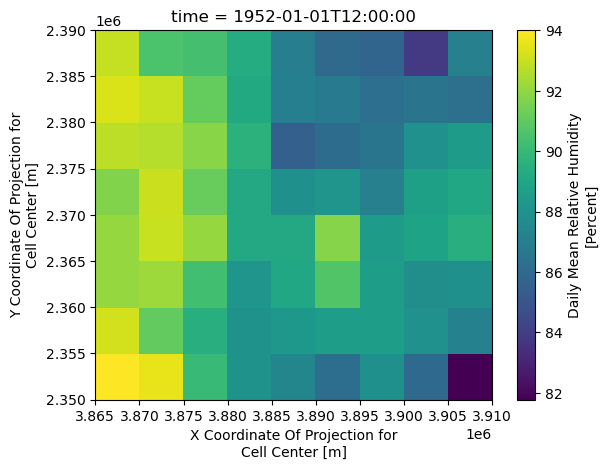

In [25]:
import xarray as xr 

da = xr.open_dataset('DE110000.nc').hurs
ds = xr.Dataset({'hurs': da})
ds.isel(time=0).hurs.plot.imshow()

In [44]:
df = ds.to_dataframe()
df.reset_index(inplace=True)
df

,time,y,x,lon,lat,hurs
0,1952-01-01 12:00:00,2352500.0,3867500.0,8.1699,47.819599,94.012001
1,1952-01-01 12:00:00,2352500.0,3872500.0,8.2390,47.820801,93.584000
2,1952-01-01 12:00:00,2352500.0,3877500.0,8.3080,47.821899,90.047997
3,1952-01-01 12:00:00,2352500.0,3882500.0,8.3770,47.822899,88.071999
4,1952-01-01 12:00:00,2352500.0,3887500.0,8.4461,47.823898,87.379997
...,...,...,...,...,...,...
26347,1952-12-31 12:00:00,2387500.0,3887500.0,8.4358,48.149399,91.783997
26348,1952-12-31 12:00:00,2387500.0,3892500.0,8.5053,48.150398,92.863998
26349,1952-12-31 12:00:00,2387500.0,3897500.0,8.5748,48.151299,92.708000
26350,1952-12-31 12:00:00,2387500.0,3902500.0,8.6443,48.152199,92.335999


In [55]:
import duckdb
with duckdb.connect('catchments.db') as con:
    con.install_extension('spatial')
    con.load_extension('spatial')
    con.execute("create table catchments as select * from st_read('merit_hydro_catchments.gpkg');")


In [63]:
import duckdb
del test_df
with duckdb.connect() as con:
    con.install_extension('spatial')
    con.load_extension('spatial')
    # con.execute("create table catchments as select * from st_read('merit_hydro_catchments.gpkg') where id='DE110000';")
    con.execute("ATTACH 'catchments.db' AS catchments (READ_ONLY);")
    con.execute("SET threads=4;")
    #con.execute("create table hurs as select time, lon, lat, hurs from df where hurs is not null and st_within(st_point(lon, lat), (select geom from catchments.catchments where id='DE110000'));")
    con.execute("create table hurs as select time, lon, lat, hurs from df where hurs is not null and st_intersects_extent(st_point(lon, lat), (select geom from catchments.catchments where id='DE110000'));")
    con.sql('select count(*) from hurs;').fetchall()
    test_df = con.sql('select time, avg(hurs) as mean from hurs group by time;').df()

<AxesSubplot:xlabel='time'>

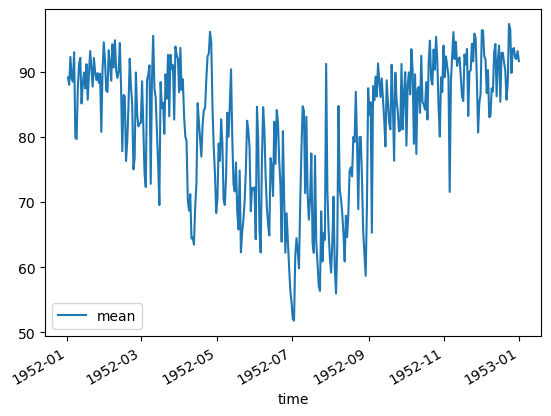

In [64]:
test_df.set_index('time').plot()